In [12]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Microtubule")
log_dir = root_dir / "Logs"
events_path = log_dir / "events.h5"

# Explore Existing Models Training Summaries

In [13]:
previous_events = None
if events_path.is_file():
    previous_events = pd.read_hdf(str(events_path), "events")
    
logs_path = {}
for model_path in log_dir.iterdir():
    if model_path.is_dir() and model_path.name != ".ipynb_checkpoints":
        logs_path[model_path.name] = list(model_path.glob("*.out.tfevents.*"))
        
events = {}

for model_name, log_path in logs_path.items():
    for single_log_path in log_path:
        
        try:
            for summary in tf.train.summary_iterator(str(single_log_path)):
                if summary.HasField("summary"):
                    datum = {}
                    datum["model_name"] = model_name
                    datum["step"] = summary.step
                    datum["wall_time"] = summary.wall_time
                    datum[summary.summary.value[0].tag] = summary.summary.value[0].simple_value

                    key_name = f"{model_name}_{summary.step}"
                    if key_name not in events.keys():
                        events[key_name] = {}

                    events[key_name].update(datum)
        except Exception:
            print(f"Error with {single_log_path}")
        
events = pd.DataFrame.from_dict(events).T
events = events.sort_values(["model_name", "step"])
events.reset_index(inplace=True, drop=True)

if previous_events is not None:
    events = pd.concat([events, previous_events])
    events.drop_duplicates(["model_name", "step"], inplace=True)
    events = events.sort_values(["model_name", "step"])

events.to_hdf(str(events_path), "events")

Error with /home/hadim/.data/Neural_Network/Maskflow/Microtubule/Logs/microtubule_detector20180624T1725/events.out.tfevents.1530458275.aw-4r14-n30
Error with /home/hadim/.data/Neural_Network/Maskflow/Microtubule/Logs/microtubule_detector20180624T1725/events.out.tfevents.1530458673.aw-4r14-n30
Error with /home/hadim/.data/Neural_Network/Maskflow/Microtubule/Logs/microtubule_detector20180624T1725/events.out.tfevents.1530458805.aw-4r14-n30
Error with /home/hadim/.data/Neural_Network/Maskflow/Microtubule/Logs/microtubule_detector20180624T1725/events.out.tfevents.1530462272.aw-4r14-n30
Error with /home/hadim/.data/Neural_Network/Maskflow/Microtubule/Logs/microtubule_detector20180624T1725/events.out.tfevents.1530462391.aw-4r14-n30
Error with /home/hadim/.data/Neural_Network/Maskflow/Microtubule/Logs/microtubule_detector20180624T1725/events.out.tfevents.1530462741.aw-4r14-n30
Error with /home/hadim/.data/Neural_Network/Maskflow/Microtubule/Logs/microtubule_detector20180624T1725/events.out.tfe

/home/hadim/conda/envs/nn/lib/python3.6/site-packages/pandas/core/generic.py:1993: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->['loss', 'model_name', 'mrcnn_bbox_loss', 'mrcnn_class_loss', 'mrcnn_mask_loss', 'rpn_bbox_loss', 'rpn_class_loss', 'step', 'val_loss', 'val_mrcnn_bbox_loss', 'val_mrcnn_class_loss', 'val_mrcnn_mask_loss', 'val_rpn_bbox_loss', 'val_rpn_class_loss', 'wall_time']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [14]:
#events = pd.read_hdf(str(events_path), "events")

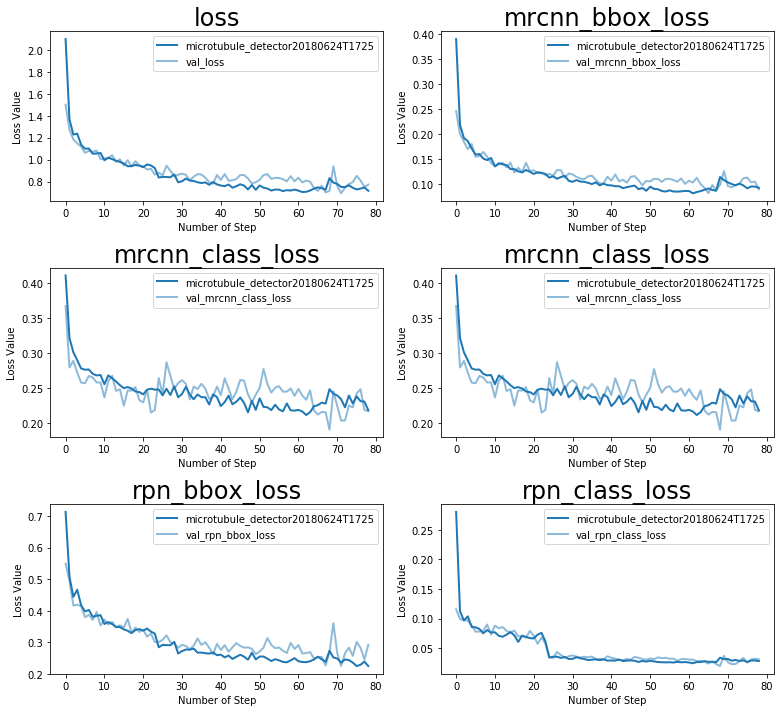

In [15]:
features = ["loss", "mrcnn_bbox_loss", "mrcnn_class_loss", "mrcnn_class_loss",
            "rpn_bbox_loss", "rpn_class_loss"]

nrows = len(features) // 2
nrows += 1 if len(features) % 2 > 0 else 0
fig, axs = plt.subplots(ncols=2, nrows=nrows, figsize=(11, 10))

for ax, feature in zip(axs.flat, features):
    for i, row in events.groupby("model_name"):
        line = ax.plot(row.step, row[f"{feature}"], lw=2, label=i)[0]
        ax.plot(row.step, row[f"val_{feature}"], lw=2, color=line.get_color(), alpha=0.5)
        ax.set_title(feature, fontsize=24)
        ax.set_xlabel("Number of Step")
        ax.set_ylabel("Loss Value")

    ax.legend()
    #ax.set_xscale("log")
    
fig.tight_layout()
fig.savefig(log_dir / "loss_values.png", dpi=200)

# Compute Precision Metrics

In [67]:
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import mrcnn
import sys
sys.path.append("../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Microtubule")
data_dir = root_dir / "Data"
log_dir = root_dir / "Logs"
config = maskflow.load_config(root_dir / "config.yml")

# Dataset
fnames = list((data_dir / "Image").glob("*.tif"))
train_fnames, validation_fnames = train_test_split(fnames, test_size=0.25, random_state=10)
dataset = maskflow.MaskflowDataset()
dataset.set_dataset(validation_fnames, config["CLASS_NAMES"])

# Load model
maskflow_config = maskflow.MaskflowConfig(config)
maskflow_config.IMAGES_PER_GPU = 1
maskflow_config.update()
model = maskflow.load_model(log_dir, maskflow_config, mode="inference")
maskflow.load_weights(model, init_with="microtubule_detector20180624T1725")

{'id': 5, 'source': '', 'path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Image/2018-05-04 ch1 15uM tubulin 1to10 hilyte GMPCPP seeds T1 10smerged-FLAT-T-10-C-0.tif'), 'mask_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Mask/2018-05-04 ch1 15uM tubulin 1to10 hilyte GMPCPP seeds T1 10smerged-FLAT-T-10-C-0.tif'), 'class_ids_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Class/2018-05-04 ch1 15uM tubulin 1to10 hilyte GMPCPP seeds T1 10smerged-FLAT-T-10-C-0.csv')}


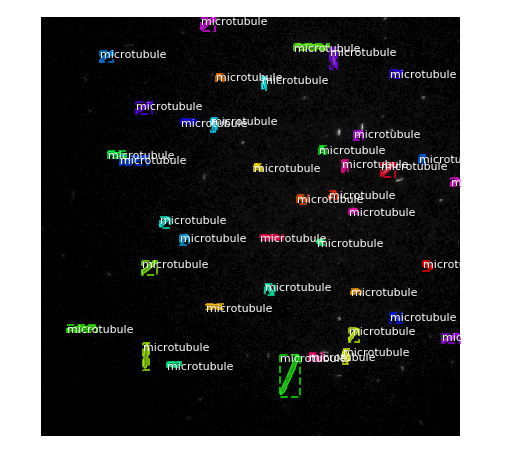

In [88]:
image_id = np.random.choice(dataset.image_ids)
image_id = 5

original_image = dataset.load_image(image_id)
original_mask, class_ids = dataset.load_mask(image_id)
args = maskflow.load_image_gt(dataset, maskflow_config, image_id, use_mini_mask=False)
_, _, _, gt_bbox, _ = args
    
info = dataset.image_info[image_id]
print(info)

# Run object detection
results = model.detect([original_image], verbose=0)

maskflow.display_instances(original_image, results[0]["rois"], results[0]["masks"],
                           results[0]["class_ids"], dataset.class_names, figsize=(8, 8))

Text(0.5,1,'Precision-Recall Curve. AP@50 = 0.5556')

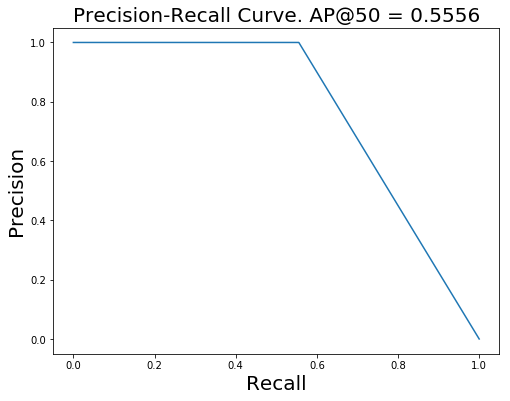

In [102]:
# Draw precision-recall curve

iou_threshold = 0.5

aps = mrcnn.utils.compute_ap(gt_bbox, class_ids, original_mask ,
                             results[0]["rois"], results[0]["class_ids"],
                             results[0]["scores"], results[0]["masks"],
                             iou_threshold=iou_threshold)
AP, precisions, recalls, overlaps = aps

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(recalls, precisions)

ax.set_xlabel("Recall", fontsize=20)
ax.set_ylabel("Precision", fontsize=20)
ax.set_title(f"Precision-Recall Curve. AP@{iou_threshold * 100:.0f} = {AP:.4f}", fontsize=20)

# Compute mAP on a dataset

In [105]:
iou_threshold = 0.5

image_ids = np.random.choice(dataset.image_ids, 2)
image_ids = [9, 5]
image_ids = dataset.image_ids

data = {}
data["ap"] = []
data["precisions"] = []
data["recalls"] = []
data["overlaps"] = []

for image_id in image_ids:
    
    print(image_id)
    
    # Load image
    original_image = dataset.load_image(image_id)
    original_mask, class_ids = dataset.load_mask(image_id)
    args = maskflow.load_image_gt(dataset, maskflow_config, image_id, use_mini_mask=False)
    _, _, _, gt_bbox, _ = args
    
    # Run detection
    results = model.detect([original_image], verbose=0)

    # Compute AP
    aps = mrcnn.utils.compute_ap(gt_bbox, class_ids, original_mask ,
                                 results[0]["rois"], results[0]["class_ids"],
                                 results[0]["scores"], results[0]["masks"],
                                 iou_threshold=iou_threshold)
    AP, precisions, recalls, overlaps = aps
    
    data["ap"].append(AP)
    data["precisions"].append(precisions)
    data["recalls"].append(recalls)
    data["overlaps"].append(overlaps)
    
data["ap"] = np.array(data["ap"])
data["precisions"] = np.array(data["precisions"])
data["recalls"] = np.array(data["recalls"])
data["overlaps"] = np.array(data["overlaps"])

print(f"Mean AP is {data['ap'].mean():.4f}")

0
1
2
3
4
5
6
7
8
9
10
11
Mean AP is 0.4859
